# Hybrid transfer learning for image classification (CIFAR)



This is a hybrid network for image classification, based on the classical quantum transfer learning scheme.

The convolutional neural network was pretrained by ResNet18, a Pytorch model made for implementing Quantum ML models. The last connected output layer is replaced with a *quantum circuit* layer that is trained on a different Qpool dataset.
The final product is a Hybrid convoluted neural network with multiple quantum filters with a classical ResNet. 

The code can be modified to deal with different CIFAR classes.

## Import Libraries

OMP (threading), pytorch, matplotlib (plotting library), and tensorflow quantum's software framework `pennylane` are imported. 

In [ ]:
%env OMP_NUM_THREADS=1
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import pennylane as qml
from pennylane import numpy as np
import time
import copy

env: OMP_NUM_THREADS=1


We now load and initialize the dataset for the cat and dog classifier. 

In [ ]:
filtered_classes = ['cat', 'dog']  # Subset of the CIFAR dataset
n_qubits = 4                       # Number of qubits
quantum = True                     # Quantum circuit
classical_model = '512_n'          # [nq = num_qubits, n = num_filtered_classes]
step = 0.001                       # Learning rate
batch_size = 8                     # Number of images for each training step
num_epochs = 3                     # Number of training epochs
q_depth = 5                        # Depth of the quantum circuit (number of variational layers needed to be pooled)
gamma_lr_scheduler = 1             # Learning rate reduction applied every 10 epochs.                  
max_layers = 15                    # Max number of layers needed
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # Seed for random number generator for numpy and quantum
start_time = time.time()           # Start the computation timer

Initialize a PennyLane with the default constructor and qubits. 

In [ ]:
dev = qml.device('default.qubit', wires = n_qubits) 

Configure PyTorch to use CUDA, only if available. Otherwise use the CPU configuration.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Import The Datasset

Import the CIFAR cats and dogs images dataset. The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard image operations like resize, crop, normalize, etc.

In [ ]:
# Transform the data and perform image preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),     # Augment data with random cropping
        transforms.RandomHorizontalFlip(),     # Augment data with random flipping
        transforms.Resize(256),                # Resize the image
        transforms.CenterCrop(224),            # Crop the image
        transforms.ToTensor(),                 # Convert the image to a tensor 
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Do the same thing to the validation dataset
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Load the CIFAR dataset
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download = True, transform = data_transforms['train'])
testset_full = torchvision.datasets.CIFAR10(root = './data', train=False,
                                       download=True, transform = data_transforms['val'])
image_datasets_full = {'train': trainset_full, 'val': testset_full}

# CIFAR classes
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get indices of only the cats and dogs
filtered_labels = [class_names.index(cl) for cl in filtered_classes]
sub_indices={'train': [], 'val': []}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):  
        if label in filtered_labels:
            sub_indices[phase].append(idx)
            
# Initialize sub-datasets according to indices
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    """Maps CIFAR labels (0,1,2,3,4,5,6,7,8,9) to the index of filtered_labels"""
    return [filtered_labels.index(label) for label in labels]

# Define number of samples
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Initialize Pytorch dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Function to plot images from loaded tensors
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Files already downloaded and verified
Files already downloaded and verified


Validate the test data batching and look at the classification images.

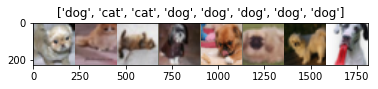

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title = [class_names[x] for x in classes])

In order to get reproducible results, we set a manual seed for the random number generator and re-initialize the data loaders.

In [ ]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

## Hybrid transfer learning model

We first define some quantum layers that will make up the quantum circuit. 
The layers are: 
1. An H_layer of Hadamard gates
2. A BY_layer of parametrized qubit rotations (y-axis)
3. An entangled layer with a series of CNOT configurations
CNOT  CNOT  CNOT  CNOT...  CNOT
    CNOT  CNOT  CNOT...  CNOT 

In [ ]:
# Define a layer 
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2): # Loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Define the quantum circuit by using the PennyLane `qnode` decorator . The structure is that of a typical variational quantum circuit:
1. All qubits are first initialized in a balanced superposition of *up*(1) and *down*(-1) states, then they are rotated according to the input parameters
2. A sequence of trainable rotation layers and constant entangling layers is applied many times. 
3. Eventually, for each qubit, the expectation value of $\langle \hat{Z}_n \rangle$ is measured. This produces a classical output vector, needed for prost processing and loss calcuations. 

In [ ]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        # Start from the H_layer state
        H_layer(n_qubits)
        # Embed features in the quantum node
        RY_layer(q_in)
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])
        # Find expectation values using the Zn Pauli calculations
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

We can now define a custom `torch.nn.Module` representing a *dressed* quantum circuit.<br>

This is a combination of the multi-layered tensors:
1. A classical pre-processing layer (`nn.Linear`)
2. A classical activation function (`F.tanh`)
3. A constant `np.pi/2.0` scaling factor.
2. The previously defined quantum circuit (`q_net`)
2. A classical post-processing layer (`nn.Linear`)

The input of the module is a batch of vectors with 512 parameters and the output is a batch of vectors with *n* outputs (one for each class of images), hence the type `512_n`. 

In [ ]:
# Create a net with the quantum net containing the processing layers
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))
        # Apply the necessary layers
        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

We are finally ready to build our full hybrid classical-quantum network. We follow the *transfer learning* approach:

1. First load the classical pre-trained network *ResNet18* from the `torchvision.models` zoo. <br> 
2. Freeze all the weights since they should not be trained.
3. Replace the last fully connected layer with our trainable dressed quantum circuit (`Quantumnet`). 

In [ ]:
# Initialize the pretrained hybrid model with resnet18
model_hybrid = torchvision.models.resnet18(pretrained=True)

# Set the type of model
for param in model_hybrid.parameters():
    param.requires_grad = False

# Add the quantum net as a parameter to the hybrid model
model_hybrid.fc = Quantumnet()

# Sync the model with the device type
model_hybrid = model_hybrid.to(device)

## Training and results
Before training the network the *loss* and *optimizer* functions must be defined. The loss will implement a *cross relative entropy loss* function and the *optimizer* will be called at each step to update model weights and optimize the CNN using the loss change.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

Schedule the learning rate to reduce itself by a factor of `gamma_lr_scheduler` every epoch so weights stay relatively stable (with the Quantum net).

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

### Model Training Function

This should return a trained model that can be used to make predictions and classifications. 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   
        best_acc_train = 0.0
        best_loss_train = 10000.0  #
        print('Training started:')
        for epoch in range(num_epochs):
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    scheduler.step()
                    model.train() 
                else:
                    # Set model to evaluate mode
                    model.eval()   
                
                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, cifar_labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model compared to previous epochs and if yes, save the weights
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results and return the trained model        
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

Now the model can be trained using the parameters and model above. 

In [ ]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)

Training started:
Phase: train Epoch: 1/3 Loss: 0.5538 Acc: 0.7223             
Phase: val   Epoch: 1/3 Loss: 0.4698 Acc: 0.7560             
Phase: train Epoch: 2/3 Loss: 0.4800 Acc: 0.7769             
Phase: val   Epoch: 2/3 Loss: 0.4098 Acc: 0.8270             
Phase: train Epoch: 3/3 Loss: 0.4722 Acc: 0.7751             
Phase: val   Epoch: 3/3 Loss: 0.4039 Acc: 0.8165             
Training completed in 676m 5s
Best test loss: 0.4039 | Best test accuracy: 0.8270


The optimal weights that achieved the best accuracy will be saved into a PyTorch file that will be created in the current working directory. The saved weights can then be loaded for testing without training again.


In [ ]:
torch.save(model_hybrid.state_dict(), 'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt')
print("Model state_dict saved.")

Model state_dict saved.


## Test the model

First, load the pre-trained weights to define the model for testing. 

In [ ]:
model_hybrid.load_state_dict(torch.load(
    'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
    )
)

Apply the model to the test and validation dataset to compute the epoch *loss* and *accuracy*.

In [ ]:
# Apply model criterion
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0
model_hybrid.eval()

# Testing loop
for inputs, cifar_labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = torch.tensor(labels_to_filtered(cifar_labels))
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it+1,n_batches+1), end='\r', flush=True)
    it += 1
                    
# Print final results
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 250/251
Test Loss: 0.4098 Test Acc: 0.8270        


## Visualize the model testing

To view the results, display the predictions of the QCNN on a batch of the cat an dog images. 

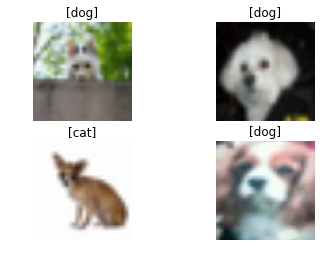

In [ ]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    # Evaluate the model
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval() 
    # Display the images and labels based on the model predictions
    with torch.no_grad():
        for i, (inputs, cifar_labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = torch.tensor(labels_to_filtered(cifar_labels))
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(filtered_classes[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
# Visualize the hbrid model
visualize_model(model_hybrid, num_images=4)


### Conclusion

We have successfully trained a cat and dog classifier using a quantum convoluted neural network (a classical CNN with a dressed quantum circuit) with over 83% accuracy. 

## References

Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:1912.08278](https://arxiv.org/abs/1912.08278), (2019).

Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. _Deep residual learning for image recognition_.
  Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016). [DOI: 10.1109/CVPR.2016.90]( https://doi.org/10.1109/CVPR.2016.90).
  
Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. [arXiv:1811.04968](https://arxiv.org/abs/1811.04968), (2018).